In [218]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.tree import export_graphviz
from sklearn.metrics import accuracy_score
plt.rc('pdf', fonttype=42)

from IPython.core.display import display, HTML
display(HTML('<style>.container { width:100% !important; }</style>'))

BIG    = 22
MEDIUM = 20
FIGWIDTH= 12
WIDTH = 0.25  # the width of the bars
NARROW=0.2

XLINE  = 523.21
YLINE  = 0.002

colors = ['#E27100', '#1b85b8', '#559e83', '#b26167']

# Starting to define standardized colors
MAE_COLOR =colors[1]
TIME_COLOR=colors[0]

In [242]:
# Combining V100 and P100 on same row for same run
# We are deleting cases where there is no run for either of the architectures
# Every column name is appended with the name of the architecture (e.g. "_V100");
# This includes the `master_index` (e.g `master_index_V100`)

df_joined = pd.read_parquet('../df_master_joined.parquet')
df_joined.master_index_P100 = df_joined.master_index_P100.astype('int64') # Make sure index is integer
df_joined.master_index_V100 = df_joined.master_index_V100.astype('int64') # Make sure index is integer
df_joined.shape


# This is an "empty" dataframe (meaning no rows), containing
# column names for numerical data only.
# The column nmaes can be used to index the columns of the
# scaled data (in master_scaled_data.npy)

df_columns_only = pd.read_parquet('../df_column_reference.parquet')


# This is a 2-D numpy array corresponding to the numerical data in 'df_master.parquet'
# The data has been scaled using the StandardScaler in scikitlearn

# Notes: 
#   - The row indices correspond to the `master_index` column of 'df_master.parquet'
#   - The columns correspond to the columns in 'df_column_reference.parquet'.
#     (e.g. can use `df.get_loc(column-name)` to get the column index)

master_data_scaled = np.load('../master_scaled_data.npy')
master_data_scaled.shape

(78330, 116)

In [243]:
df_columns_only.columns

Index(['inst_per_warp', 'branch_efficiency', 'warp_execution_efficiency',
       'warp_nonpred_execution_efficiency', 'inst_replay_overhead',
       'shared_load_transactions_per_request',
       'shared_store_transactions_per_request',
       'local_load_transactions_per_request',
       'local_store_transactions_per_request', 'gld_transactions_per_request',
       ...
       'cf_fu_utilization', 'special_fu_utilization',
       'half_precision_fu_utilization', 'single_precision_fu_utilization',
       'double_precision_fu_utilization', 'flop_hp_efficiency',
       'flop_sp_efficiency', 'flop_dp_efficiency', 'sysmem_read_utilization',
       'sysmem_write_utilization'],
      dtype='object', length=116)

In [244]:
temp_col = df_joined['dram_write_throughput_V100'] + df_joined['dram_read_throughput_V100']
temp_col2 = df_joined['dram_write_throughput_V100'] + df_joined['dram_read_throughput_V100']
#df_joined =df_joined[temp_col2>10e9]

df_joined= df_joined[temp_col>10e9]

In [245]:

df = df_joined.copy()  # Start with all of df_joined

# Target index and values (values are NOT in master_data_scaled)
target_index = df['master_index_V100'].values
target = df['memory_bound_V100'].values

# Training data index and values (values ARE in master_data_scaled)
data_index = df['master_index_P100'].values
data = master_data_scaled[ data_index ]

# Need to drop 'dram_read_throughput' and 'dram_write_throughput'
indices = []
for i, col in enumerate(df_columns_only.columns):
    if col not in ['dram_read_throughput', 'dram_write_throughput','dram_write_transactions','dram_read_transactions']:
    #if col not in not_import:
        indices.append(i)       
data = data[:,indices]

## Kernels Profiled

In [246]:
kernels = []
for i in df_joined['application_name_V100']:
    if i not in kernels:
        kernels.append(i)
        
kernels

['backprop', 'gaussian', 'hybridsort', 'kmeans', 'srad', 'stream']

## Baseline Comparison

Mean Absolute Error: 216.44
Mean Absolute Percentage Error: 284.38398656551936
R2 Score -0.06439818627230554


Text(0.5,1,'Baseline Memory Throughput - MAE: 216.44')

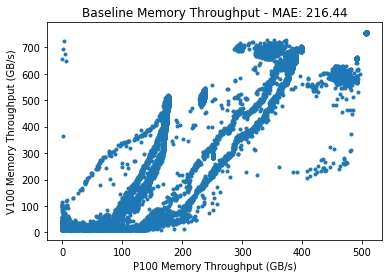

In [247]:
V100_throughput = (df_joined['dram_read_throughput_V100'] + df_joined['dram_write_throughput_V100']).values
P100_throughput = (df_joined['dram_read_throughput_P100'] + df_joined['dram_write_throughput_P100']).values
plt.plot(P100_throughput/1024/1024/1024, V100_throughput/1024/1024/1024,'.')
plt.xlabel('P100 Memory Throughput (GB/s)')
plt.ylabel('V100 Memory Throughput (GB/s)')
errors = abs(V100_throughput - P100_throughput)/1024/1024/1024
mean_error = round(np.mean(errors),2)
print('Mean Absolute Error:', round(np.mean(errors),2))
print('Mean Absolute Percentage Error:',mean_absolute_percentage_error(P100_throughput/1024/1024/1024, V100_throughput/1024/1024/1024))
print("R2 Score", r2_score(V100_throughput,P100_throughput))
plt.title('Baseline Memory Throughput - MAE: ' + str(mean_error))

#plt.savefig('Throughput_Prediction_Figures/predict_result.pdf')

## Splitting and Loading data for ML models

In [282]:
df = df_joined.copy() 

# Target index and values (values are NOT in master_data_scaled)
target_index = df['master_index_V100'].values
target = df['memory_bound_V100'].values

# Training data index and values (values ARE in master_data_scaled)
data_index = df['master_index_P100'].values
data = master_data_scaled[ data_index ]

top_features = ['gld_transactions', 'l2_write_transactions', 'l2_tex_write_transactions','tex_cache_transactions','gst_transactions']
# Need to drop 'dram_read_throughput' and 'dram_write_throughput'
indices = []
for i, col in enumerate(df_columns_only.columns):
    #if col not in ['dram_read_throughput', 'dram_write_throughput','dram_write_transactions','dram_read_transactions']:
    if col in top_features:
        indices.append(i)       
data = data[:,indices]

In [283]:
df['master_index_V100'].shape

(21487,)

In [284]:
# Split the data for training
(
    X_train, X_test,
    y_train, y_test,
    #data_index_train, data_index_test,
    #target_index_train, target_index_test
) = train_test_split(
    data,
    target,
    #data_index,
    #target_index,
    random_state=42,
    test_size=.33
)

## Classification

In [285]:
clf = RandomForestClassifier(n_jobs=2, n_estimators=1000,max_depth=2)
model = clf.fit(X_train, y_train)
#model = clf.fit(data,target)
y_test_predict = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test,y_test_predict))


Accuracy: 0.9486673247778875


## Regression

In [286]:
data.shape

(21487, 5)

In [287]:
df_target = (df_joined['dram_read_throughput_V100'] + df_joined['dram_write_throughput_V100']).values
# Split the data for training
(
    X_train, X_test,
    y_train, y_test,
    #data_index_train, data_index_test,
    #target_index_train, target_index_test
) = train_test_split(
    data,
    df_target,
    #data_index,
    #target_index,
    random_state=42,
    test_size=.33
)

In [288]:
data.shape

(21487, 5)

In [289]:
data.shape
"""y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)"""

'y_train = y_train.reshape(-1,1)\ny_test = y_test.reshape(-1,1)'

In [290]:
clf = RandomForestRegressor(n_jobs=2, n_estimators=200, max_depth=100)
reg_model = clf.fit(X_train, y_train)

In [291]:
y_test_predict = clf.predict(X_test)


In [292]:
import numpy as np

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true = y_true
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [293]:
# Calculate mean absolute percentage error (MAPE)
#mape = np.mean(100 * (errors /( y_test_gb+.00000001)))
# Compare to baseline
#improvement_baseline = 100 * abs(mape - baseline_mape) / baseline_mape
#print('Improvement over baseline:', round(improvement_baseline, 2), '%.')
# Calculate and display accuracy
#accuracy = 100 - mape
#print('Accuracy:', round(accuracy, 2), '%.')


In [294]:
raw_error = y_test_predict-y_test


In [295]:
raw_error.min()/1024/1024/1024
raw_error.max()/1024/1024/1024

445.2421822807302

In [296]:
errors = abs(y_test_predict - y_test)/1024/1024/1024
y_test_predict_gb = y_test_predict/1024/1024/1024
y_test_gb = y_test/1024/1024/1024
mean_error = round(np.mean(errors),2)
print('Mean Absolute Error:', round(np.mean(errors),2))
print("Mean absolute percentage error:",mean_absolute_percentage_error(y_test_gb,y_test_predict_gb))

Mean Absolute Error: 18.93
Mean absolute percentage error: 13.296347266090836


In [297]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test_gb,y_test_predict_gb,squared=False)

35.657360798568504

Text(0,0.5,'Predicted')

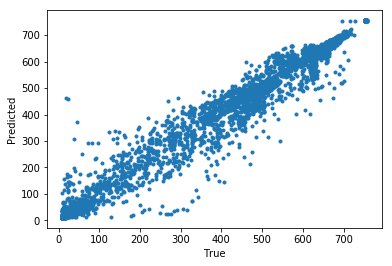

In [298]:
plt.plot(y_test/1024/1024/1024, y_test_predict/1024/1024/1024,'.')
plt.xlabel('True')
plt.ylabel('Predicted')


In [189]:
# Split the data for training
import xgboost as xgb
(
    X_train, X_test,
    y_train, y_test,
    #data_index_train, data_index_test,
    #target_index_train, target_index_test
) = train_test_split(
    data,
    df_target,
    random_state=42,
    test_size=.33
)
model = xgb.XGBRegressor(n_estimators=1000, max_depth=150, eta=0.1, subsample=0.7, colsample_bytree=0.8)
eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train, y_train, eval_metric=["rmse", "mae"], eval_set=eval_set, verbose=True)

[0]	validation_0-rmse:457231138816.00000	validation_0-mae:377592217600.00000	validation_1-rmse:458517741568.00000	validation_1-mae:378788052992.00000
[1]	validation_0-rmse:411743092736.00000	validation_0-mae:339940540416.00000	validation_1-rmse:412919955456.00000	validation_1-mae:341056028672.00000
[2]	validation_0-rmse:370833096704.00000	validation_0-mae:306087854080.00000	validation_1-rmse:371935019008.00000	validation_1-mae:307143376896.00000
[3]	validation_0-rmse:334021885952.00000	validation_0-mae:275603685376.00000	validation_1-rmse:335054307328.00000	validation_1-mae:276620902400.00000
[4]	validation_0-rmse:300918571008.00000	validation_0-mae:248209293312.00000	validation_1-rmse:301914390528.00000	validation_1-mae:249212092416.00000
[5]	validation_0-rmse:271117352960.00000	validation_0-mae:223516311552.00000	validation_1-rmse:272097525760.00000	validation_1-mae:224524468224.00000
[6]	validation_0-rmse:244301037568.00000	validation_0-mae:201287204864.00000	validation_1-rmse:24526

KeyboardInterrupt: 

In [ ]:
y_test_predict = model.predict(X_test)
errors = abs(y_test_predict - y_test)/1024/1024/1024
mean_error = round(np.mean(errors),2)
print('Mean Absolute Error:', round(np.mean(errors),2))

In [ ]:
plt.plot(y_test, y_test_predict,'.')
plt.xlabel('V100 Throughput')
plt.ylabel('V100 Throughput Prediction')
plt.title('9 Features - MAE: ' + str(mean_error))
print("R2 Score", r2_score(y_test,y_test_predict))

In [64]:
print("Mean absolute percentage error:",mean_absolute_percentage_error(y_test,y_test_predict))

Mean absolute percentage error: 271.46210302250853


## Feature Importance and Reduced feature regression results
Similar erors 

In [222]:
#[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

In [331]:
"""
Variable: l2_atomic_throughput Importance: 0.6087
Variable: l2_read_transactions Importance: 0.281
Variable: gld_transactions     Importance: 0.0587
Variable: inst_executed        Importance: 0.0117
Variable: gst_transactions     Importance: 0.0081
Variable: l2_write_transactions Importance: 0.0075
Variable: stall_memory_throttle Importance: 0.0067
Variable: l2_write_throughput  Importance: 0.0018
Variable: shared_store_throughput Importance: 0.0013

"""
importances = list(reg_model.feature_importances_)
feature_list = [c for c in df_columns_only.columns if c not in ['dram_read_throughput', 'dram_write_throughput']]
#feature_list = df_columns_only.columns
print(len(feature_list))
feature_importances = [(feature, round(importance, 4)) for feature, importance in zip(feature_list, importances)]\
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]


114
Variable: warp_execution_efficiency Importance: 0.8943
Variable: inst_per_warp        Importance: 0.063
Variable: warp_nonpred_execution_efficiency Importance: 0.0127
Variable: local_store_transactions_per_request Importance: 0.0124
Variable: branch_efficiency    Importance: 0.0105
Variable: inst_replay_overhead Importance: 0.0051
Variable: shared_store_transactions_per_request Importance: 0.0013
Variable: shared_load_transactions_per_request Importance: 0.0006
Variable: local_load_transactions_per_request Importance: 0.0


[None, None, None, None, None, None, None, None, None]

In [332]:
not_import = []
for x in feature_importances:
    #print(x)
    if 0 in x or x[1] < 0.009:
        #print(x[0])
        not_import.append(x[0])
len(not_import)

4

In [333]:
df_columns_only['l2_atomic_throughput']

Series([], Name: l2_atomic_throughput, dtype: float64)

In [334]:

df = df_joined.copy()  # Start with all of df_joined

df_target = (df_joined['dram_read_throughput_V100'] + df_joined['dram_write_throughput_V100']).values

not_import.append('dram_read_throughput')
not_import.append('dram_write_throughput')
not_import.append('dram_write_transactions')
not_import.append('dram_read_transactions')

important_features = ['l2_atomic_throughput', 'l2_read_transactions','shared_store_throughput','gld_transactions','inst_executed','gst_transactions','l2_write_transactions','stall_memory_throttle','l2_write_throughput']
# Training data index and values (values ARE in master_data_scaled)
data_index = df['master_index_P100'].values
data = master_data_scaled[ data_index ]

# Need to drop 'dram_read_throughput' and 'dram_write_throughput'
indices = []
for i, col in enumerate(df_columns_only.columns):
    #if col not in ['dram_read_throughput', 'dram_write_throughput','dram_write_transactions','dram_read_transactions']:
    #if col not in not_import:
    #print(col)
    if col in important_features:
        print(col)
        indices.append(i)       
data = data[:,indices]

gld_transactions
gst_transactions
l2_read_transactions
l2_write_transactions
l2_write_throughput
shared_store_throughput
inst_executed
l2_atomic_throughput
stall_memory_throttle


In [335]:
# Split the data for training
(
    X_train, X_test,
    y_train, y_test,
    #data_index_train, data_index_test,
    #target_index_train, target_index_test
) = train_test_split(
    data,
    df_target,
    #data_index,
    #target_index,
    random_state=42,
    test_size=.33
)

In [336]:
X_train.shape

(21634, 9)

In [337]:
clf = RandomForestRegressor(n_jobs=2, n_estimators=200, max_depth=100)
reg_model = clf.fit(X_train, y_train)

In [338]:
y_test_predict = clf.predict(X_test)
errors = abs(y_test_predict - y_test)/1024/1024/1024
y_test_predict_gb = y_test_predict/1024/1024/1024
y_test_gb = y_test/1024/1024/1024
mean_error = round(np.mean(errors),2)
print('Mean Absolute Error:', round(np.mean(errors),2))
print("Mean absolute percentage error:",mean_absolute_percentage_error(y_test_gb,y_test_predict_gb))

Mean Absolute Error: 12.57
Mean absolute percentage error: 504915450.48913145


In [339]:
# Performance metrics
errors = abs(y_test_predict - y_test)
print('Average absolute error:', round(np.mean(errors), 2)/1000/1000/1000, 'GB/s')
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / (y_test+.00001))
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Average absolute error: 13.498968482 GB/s
Accuracy: -54214842891809.65 %.


In [340]:
#creating list of features that are used
new_columns = []
not_import.append('dram_write_throughput')
not_import.append('dram_read_throughput')
for i, col in enumerate(df_columns_only.columns):
    if col not in not_import:
        new_columns.append(col)       
new_columns


['inst_per_warp',
 'branch_efficiency',
 'warp_execution_efficiency',
 'warp_nonpred_execution_efficiency',
 'local_store_transactions_per_request',
 'gld_transactions_per_request',
 'gst_transactions_per_request',
 'shared_store_transactions',
 'shared_load_transactions',
 'local_load_transactions',
 'local_store_transactions',
 'gld_transactions',
 'gst_transactions',
 'sysmem_read_transactions',
 'sysmem_write_transactions',
 'l2_read_transactions',
 'l2_write_transactions',
 'global_hit_rate',
 'local_hit_rate',
 'gld_requested_throughput',
 'gst_requested_throughput',
 'gld_throughput',
 'gst_throughput',
 'local_memory_overhead',
 'tex_cache_hit_rate',
 'l2_tex_read_hit_rate',
 'l2_tex_write_hit_rate',
 'tex_cache_throughput',
 'l2_tex_read_throughput',
 'l2_tex_write_throughput',
 'l2_read_throughput',
 'l2_write_throughput',
 'sysmem_read_throughput',
 'sysmem_write_throughput',
 'local_load_throughput',
 'local_store_throughput',
 'shared_load_throughput',
 'shared_store_throu

In [341]:
importances = list(reg_model.feature_importances_)
print(len(not_import))
feature_list = [c for c in df_columns_only.columns if c not in not_import]
#feature_list = df_columns_only.columns
print(len(feature_list))
feature_importances = [(feature, round(importance, 4)) for feature, importance in zip(feature_list, importances)]\
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

10
108


In [342]:
x_values = list(range(len(importances)))
x_values

[0, 1, 2, 3, 4, 5, 6, 7, 8]

Text(0.5,1,'Cumulative Importances')

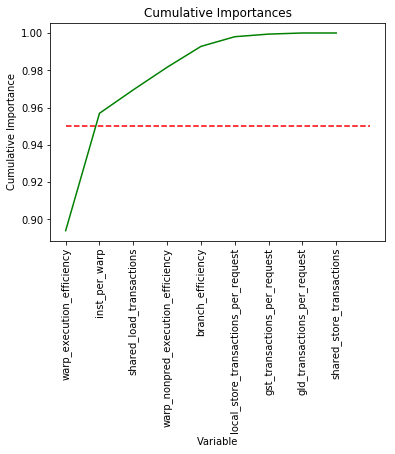

In [343]:
x_values = list(range(len(importances)))
# List of features sorted from most to least important
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]
# Cumulative importances
cumulative_importances = np.cumsum(sorted_importances)
# Make a line graph
plt.plot(x_values, cumulative_importances, 'g-')
# Draw line at 95% of importance retained
plt.hlines(y = 0.95, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')
# Format x ticks and labels
plt.xticks(x_values, sorted_features, rotation = 'vertical')
# Axis labels and title
plt.xlabel('Variable'); plt.ylabel('Cumulative Importance'); plt.title('Cumulative Importances')

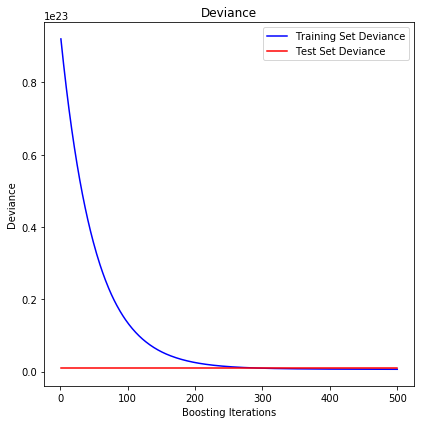

In [344]:
from sklearn import ensemble
from sklearn.metrics import mean_squared_error

params = {
    "n_estimators": 500,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.01,
}
reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(X_train, y_train)
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred in enumerate(reg.staged_predict(X_test)):
    test_score[i] = reg.loss_(y_test, y_test_predict)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Deviance")
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    reg.train_score_,
    "b-",
    label="Training Set Deviance",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, test_score, "r-", label="Test Set Deviance"
)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance")
fig.tight_layout()
plt.show()

R2 Score 0.9903461977658342


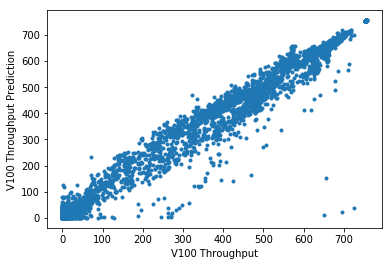

In [345]:
#y_test_predict_gb = y_test_predict/1024/1024/1024
#y_test_gb = y_test/1024/1024/1024
plt.plot(y_test_gb, y_test_predict_gb,'.')
plt.xlabel('V100 Throughput')
plt.ylabel('V100 Throughput Prediction')
#plt.title('4 Features - MAE: ' + str(mean_error))
print("R2 Score", r2_score(y_test_gb,y_test_predict_gb))

In [177]:

# Performance metrics
errors = abs(predict - test_labels)
print('Average absolute error:', round(np.mean(errors), 2), 'degrees.')
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

NameError: name 'important_train_features' is not defined